=== WARNING ===
Missing samples  [('HG02818', 'HiFi'), ('HG03125', 'HiFi'), ('HG03486', 'HiFi')]
===== pct_scaffolded =====
count    82.000000
mean     96.393537
std       2.800341
min      89.720000
25%      93.397500
50%      97.935000
75%      98.337500
max      98.770000
Name: pct_scaffolded, dtype: float64
=== HiFi
count    22.000000
mean     91.934091
std       0.952934
min      89.720000
25%      91.352500
50%      91.975000
75%      92.470000
max      93.510000
Name: pct_scaffolded, dtype: float64
=== CLR
count    60.000000
mean     98.028667
std       0.555394
min      95.960000
25%      97.815000
50%      98.210000
75%      98.382500
max      98.770000
Name: pct_scaffolded, dtype: float64
===== pct_scaffolded_full_support =====
count    82.000000
mean     87.656707
std       3.011719
min      80.480000
25%      85.070000
50%      87.975000
75%      90.020000
max      93.740000
Name: pct_scaffolded_full_support, dtype: float64
=== HiFi
count    22.000000
mean     88.809091
std

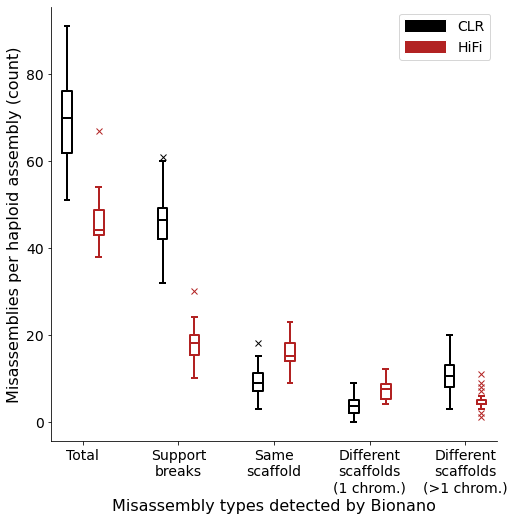

In [3]:
import os
import importlib

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines

"""
What does this do?
Read the preprocessed/aggregated BNG stats file generated by "process_bng_hybrid.py"
and create supp. figure and print statistics (number of breaks per assembly)

Follows generic plotting notebook logic
"""


plot_aux_module = '/home/local/work/code/github/project-diploid-assembly/notebooks/aux_mods/plot_aux.py'
plot_aux_spec = importlib.util.spec_from_file_location("plot_aux", plot_aux_module)
plot_aux = importlib.util.module_from_spec(plot_aux_spec)
plot_aux_spec.loader.exec_module(plot_aux)

samples = plot_aux.load_sample_table()
hexcodes, rgbcodes, popmap = plot_aux.load_population_annotation()
prop = plot_aux.get_plot_property

pipeline_version = 'v12'

stats_path = '/home/local/work/data/hgsvc/figSX_panels/bng_summary'
out_path = os.path.join(stats_path, pipeline_version, 'figSX_panel_bngbreaks')
cache_file = os.path.join(stats_path, 'cache_{}.h5'.format(pipeline_version))

save_fig = False
print_stats = True
dump_table = False


def load_hybrid_stats(tsv_file):
    
    df = pd.read_csv(tsv_file, sep='\t', header=0)
    
    num_contigs = df.shape[0]
    largest_full_support = df.loc[df['BNG_unsupported'] == 0, 'BNG_supported'].max()
    num_full_support = df.loc[df['BNG_unsupported'] == 0, :].shape[0]
    size_full_support = df.loc[df['BNG_unsupported'] == 0, 'BNG_supported'].sum()
    num_any_support = df.loc[df['BNG_supported'] > 0, :].shape[0]
    
    sum_stats = df.sum(axis=0)
    sum_stats.drop('contig_name', inplace=True)
    sum_stats = sum_stats.astype('int64')
    sum_stats['num_contigs'] = num_contigs
    sum_stats['num_ctg_full_support'] = num_full_support
    sum_stats['num_ctg_any_support'] = num_any_support
    sum_stats['bp_ctg_full_support'] = size_full_support
    sum_stats['bp_largest_ctg_full_support'] = largest_full_support
    sum_stats['bp_assembly_length'] = sum_stats['BNG_unsupported'] + sum_stats['BNG_supported']
    sum_stats['pct_scaffolded'] = ((sum_stats['BNG_supported'] / sum_stats['bp_assembly_length']) * 100).round(2)
    sum_stats['pct_scaffolded_full_support'] = ((sum_stats['bp_ctg_full_support'] / sum_stats['bp_assembly_length']) * 100).round(2)
    sum_stats['bp_scaffolded'] = sum_stats['BNG_supported']
    sum_stats['bp_discarded'] = sum_stats['BNG_unsupported']

    sum_stats.drop(['BNG_supported', 'BNG_unsupported'], inplace=True)
    
    return sum_stats

def extract_assembly_type(file_name):
    assmt = None
    if '_nhr-' in file_name:
        assmt = 'NHR', 0
    elif 'h1-un' in file_name:
        assmt = 'HAP', 10
    elif 'h2-un' in file_name:
        assmt = 'HAP', 20
    else:
        raise ValueError('ASSMT: {}'.format(file_name))
    if assmt is None:
        raise ValueError('ASSMT: {}'.format(file_name))
    return assmt


if not os.path.isfile(cache_file):
    stats_files = plot_aux.load_plot_data_files(
        stats_path,
        '.contig-stats.tsv',
        pipeline_version
    )

    sample_platform = [plot_aux.extract_sample_platform(os.path.basename(f)) for f in stats_files]
    assembly_types = [extract_assembly_type(os.path.basename(f)) for f in stats_files]
    hybrid_stats = [load_hybrid_stats(sf) for sf in stats_files]

    row_index = []
    for (sample, platform), (assmt, hap) in zip(sample_platform, assembly_types):
        super_pop = samples[sample]['super_population']
        pop = samples[sample]['population']
        row_index.append((sample, super_pop, pop, platform, assmt, hap))


    df = pd.concat(hybrid_stats, axis=1, ignore_index=False)
    df = df.transpose()

    df.index = pd.MultiIndex.from_tuples(
        row_index,
        names=['sample', 'super_pop', 'pop', 'platform', 'assembly', 'hap']
    )
    dtypes = dict()
    for c in df.columns:
        if 'pct' in c:
            dtypes[c] = 'float64'
        else:
            dtypes[c] = 'int64'
    df = df.astype(dtypes)
    df.to_hdf(cache_file, 'cache', format='fixed')

df = pd.read_hdf(cache_file, 'cache')
    
errors, missing = plot_aux.check_cache_consistency(df)
if errors:
    raise ValueErrors('Skip sample(s) in cache: {}'.format(errors))
if missing:
    print('=== WARNING ===')
    print('Missing samples ', sorted(missing))
    print('===============')


def plot_misassemblies(sample_stats):
    
    bar_width = prop('bar_width')
    
    fig, axis = plt.subplots(figsize=(8,8))
    
    break_types = [
        'contig_breaks',
        'support_breaks',
        'local_breaks',
        'global_breaks',
        'chimeric_breaks'
    ]
    break_label = [
        'Total',
        'Support\nbreaks',
        'Same\nscaffold',
        'Different\nscaffolds\n(1 chrom.)',
        'Different\nscaffolds\n(>1 chrom.)'
        
    ]
    label_pos = []
    x_pos_counter = 0
    for platform in ['CLR', 'HiFi']:

        platform_values = sample_stats.xs(platform, level='platform')

        platform_color = plot_aux.get_platform_color(platform)

        for bt in break_types:
            axis.boxplot(
                platform_values[bt],
                notch=False,
                sym='x',
                widths=bar_width,
                positions=[x_pos_counter],
                boxprops={
                    'color': platform_color,
                    'linewidth': 2
                },
                meanprops={
                    'color': platform_color,
                    'linewidth': 2
                },
                medianprops={
                    'color': platform_color,
                    'linewidth': 2
                },
                whiskerprops={
                    'color': platform_color,
                    'linewidth': 2
                },
                flierprops={
                    'color': platform_color,
                    'linewidth': 2,
                    'markersize': 6,
                    'markerfacecolor': platform_color,
                    'markeredgecolor': platform_color
                },
                capprops={
                    'color': platform_color,
                    'linewidth': 2
                }
            )
            if platform == 'CLR':
                label_pos.append(x_pos_counter + 0.5)
            x_pos_counter += 3
        x_pos_counter = 1

    
    axis.set_xlabel(
        'Misassembly types detected by Bionano',
        fontsize=prop('fontsize_axis_label')
    )

    axis.set_ylabel(
        'Misassemblies per haploid assembly (count)',
        fontsize=prop('fontsize_axis_label')
    )

    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)

    axis.set_xticks(label_pos)
    axis.set_xticklabels(break_label)
    
    axis.tick_params(
        axis='both',
        which='major',
        labelsize=prop('fontsize_axis_ticks')
    )
    
    # build custom legend
    custom_patches = [
        patches.Patch(
            facecolor=plot_aux.get_platform_color('CLR'),
            edgecolor='white',
            label='CLR'
        ),
        patches.Patch(
            facecolor=plot_aux.get_platform_color('HiFi'),
            edgecolor='white',
            label='HiFi',
        ),
    ]
    
    axis.legend(
        handles=custom_patches,
        loc='upper right',
        handlelength=3,
        handleheight=1,
        prop={'size': prop('fontsize_legend')}
    )
            
    extra_artists = []
    
    return fig, extra_artists

fig, exart = plot_misassemblies(df)

if print_stats:
    for s in ['pct_scaffolded', 'pct_scaffolded_full_support']:
        print('===== {} ====='.format(s))
        print(df[s].describe())

        hifi = df.xs('HiFi', level='platform')
        print('=== HiFi')
        print(hifi[s].describe())

        clr = df.xs('CLR', level='platform')
        print('=== CLR')
        print(clr[s].describe())
    print('=== Breaks per assembly')
    print(df['contig_breaks'].describe())
    

if dump_table:
    dump_order = [
        'bp_assembly_length',
        'num_contigs',
        'bp_scaffolded',
        'pct_scaffolded',
        'bp_discarded',
        'num_ctg_full_support',
        'num_ctg_any_support',
        'bp_ctg_full_support',
        'pct_scaffolded_full_support',
        'bp_largest_ctg_full_support',
        'contig_breaks',
        'support_breaks',
        'local_breaks',
        'global_breaks',
        'chimeric_breaks'
    ]
    df.sort_index(level=['platform', 'super_pop', 'pop', 'sample', 'hap'], inplace=True)
    df = df[dump_order]
    df.to_csv(os.path.join(stats_path, 'bng_stats.tsv'), sep='\t', header=True, index=True)
    print(df.head())